In [35]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit


In [36]:
transform = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [37]:

classes = ('Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia')

In [38]:
train_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/train'
test_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/val'

# Create datasets from the directories
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

In [39]:
#validation split ensuring equal represntation of classes

class_labels = np.array(train_dataset.targets)

validation_size = 0.2

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=42)


train_indices, validation_indices = next(stratified_splitter.split(train_dataset, class_labels))

# Create a balanced validation subset
validation_targets = class_labels[validation_indices]
unique_classes, class_counts = np.unique(validation_targets, return_counts=True)
min_class_count = min(class_counts)

balanced_validation_indices = []
for cls in unique_classes:
    cls_indices = validation_indices[validation_targets == cls]
    balanced_validation_indices.extend(np.random.choice(cls_indices, min_class_count, replace=False))

# Create subsets using the indices
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
validation_subset = torch.utils.data.Subset(train_dataset, balanced_validation_indices)
print(type(train_subset),type(validation_subset))

# Now train_subset and validation_subset contain data with balanced class representation





<class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [40]:
batch_size=64
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_subset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(type(trainloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [41]:
# Check images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("the images batch",images.shape)

print("a single item",images[3].shape)
print("label of item",labels[3].item())

the images batch torch.Size([64, 3, 256, 256])
a single item torch.Size([3, 256, 256])
label of item 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
(3, 256, 256)
(256, 256, 3)


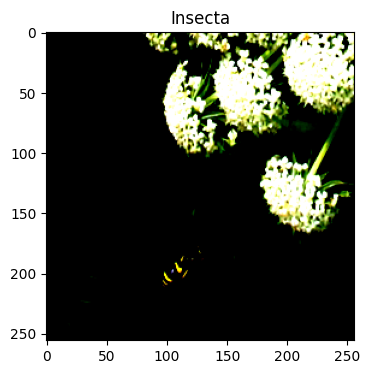

In [42]:
#visualising
img = images[3]
print(type(img))
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)
plt.figure(figsize = (4,4))
plt.imshow(npimg)
plt.title(classes[labels[3]])
plt.show()


In [43]:
def imshow(img,figsize=(8,8)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


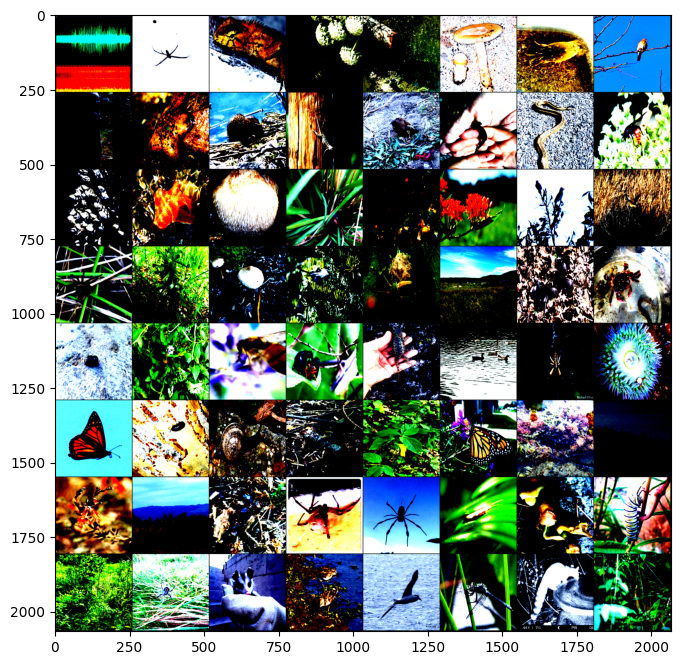

Amphibia Arachnida Reptilia Insecta Mammalia Fungi Animalia Aves Mollusca Animalia Mammalia Reptilia Mammalia Amphibia Reptilia Insecta Animalia Animalia Fungi Mollusca Animalia Plantae Aves Aves Arachnida Plantae Fungi Aves Arachnida Mammalia Reptilia Animalia Insecta Insecta Insecta Arachnida Reptilia Aves Arachnida Animalia Insecta Animalia Mollusca Mollusca Plantae Insecta Mollusca Aves Plantae Mammalia Amphibia Arachnida Arachnida Insecta Fungi Insecta Aves Arachnida Mammalia Aves Aves Insecta Mammalia Mammalia


In [44]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(64)))

In [47]:


class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, num_filters=[32, 32, 32, 32, 64], kernel_size=3, pool_size=2, dense_neurons=100):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        for out_channels in num_filters:
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(pool_size),
                    nn.Dropout(0.2)  # Adding dropout with probability 0.2
                )
            )
            in_channels = out_channels
        
        # Define dense layers
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters[-1] * (256 // (pool_size**len(num_filters))) * (256 // (pool_size**len(num_filters))), dense_neurons),
            nn.ReLU(),
            nn.Dropout(0.2),  # Adding dropout with probability 0.2
            nn.Linear(dense_neurons, num_classes)
        )
        
    def forward(self, x):
        # Pass input through convolutional layers
        for layer in self.conv_layers:
            x = layer(x)
        
        # Pass output through dense layers
        x = self.dense_layers(x)
        return x


# Instantiate the model
model = CNN()
print(model)
out=model(images)
print(out)
print(out.shape) # 64*10



CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1-3): 3 x Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_f

In [48]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [49]:
net = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [50]:
def evaluation(dataloader):
    total, correct = 0, 0
    
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
                
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [52]:
loss_epoch_arr = []
train_accuracy=[]
validation_accuracy=[]
max_epochs = 5

n_iters = np.ceil(10000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 1000 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
    t_acc=evaluation(trainloader)
    model.eval()
    v_acc=evaluation(validationloader)
    train_accuracy.append(t_acc)
    validation_accuracy.append(v_acc)
        
    print('Epoch: %d/%d, Test acc: %0.2f, validayion acc: %0.2f,Train acc: %0.2f , loss: %0.2f'%(
        epoch, max_epochs, 
        evaluation(testloader),v_acc,t_acc,loss.item()))
    model.train()
    
    
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/157, Loss: 1.90
Epoch: 0/5, Test acc: 30.55, validayion acc: 29.60,Train acc: 32.39 , loss: 2.04
Iteration: 0/157, Loss: 1.85
Epoch: 1/5, Test acc: 30.50, validayion acc: 30.90,Train acc: 35.09 , loss: 2.03
Iteration: 0/157, Loss: 1.72


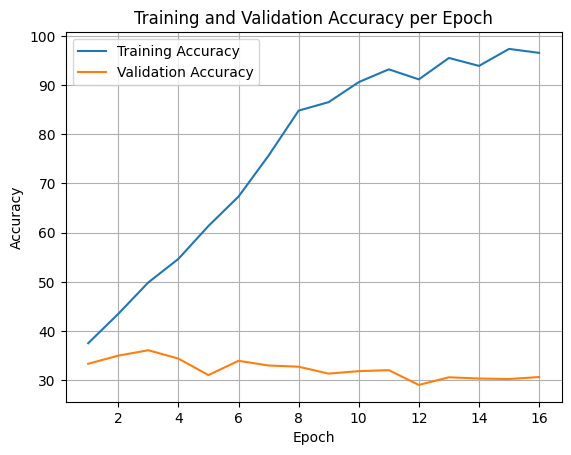

In [34]:
plt.plot(range(1, max_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, max_epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#visualising output of layers
net = net.to('cpu')
out = net(images)
print(out.shape)

torch.Size([64, 10])


In [18]:

out = net.conv_layers[0](images)
out.shape

torch.Size([64, 32, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 200x200 with 0 Axes>

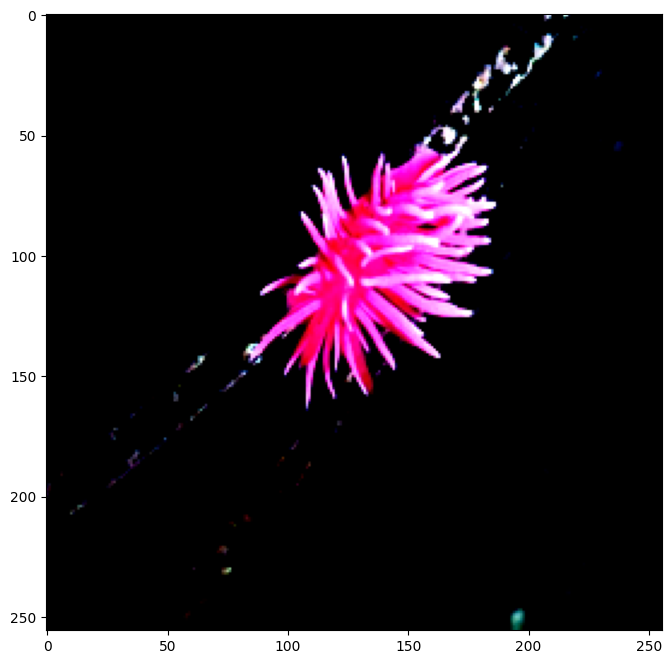

In [20]:
image_id = 40
plt.figure(figsize = (2,2))
imshow(images[image_id,])

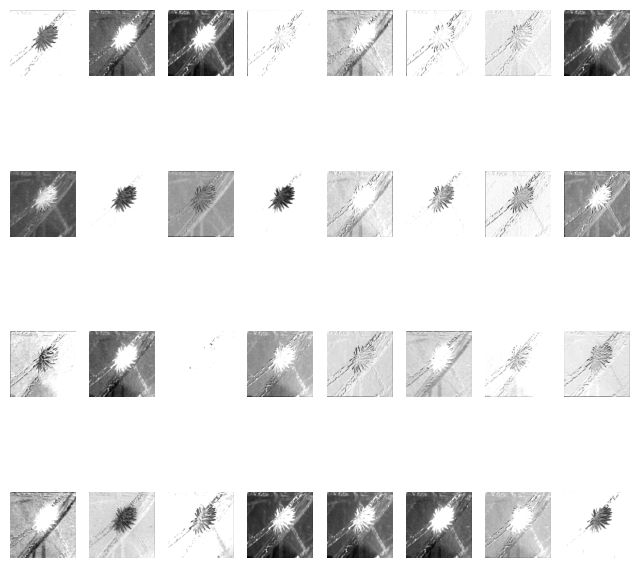

In [27]:
plt.figure(figsize=(8, 8))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)  # Create subplot
    ax.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")  # Plot image on subplot
    ax.axis('off')  # Turn off axis labels

plt.show()
